In [1]:
!git clone https://github.com/facebookresearch/fastText.git
!pip install fastText
!rm -rf fastText

!pip install transformers > /dev/null

!pip install geopy

!pip install optuna

Cloning into 'fastText'...
remote: Enumerating objects: 3854, done.
remote: Total 3854 (delta 0), reused 0 (delta 0), pack-reused 3854
Receiving objects: 100% (3854/3854), 8.23 MiB | 29.55 MiB/s, done.
Resolving deltas: 100% (2416/2416), done.
     |████████████████████████████████| 71kB 2.8MB/s 
  Created wheel for fastText: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3093711 sha256=d8fd9e382557a181ac8d96d798b3c8a8db3e9b04bcb0247b5a6d9a58c386e1d2
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fastText
     |████████████████████████████████| 296kB 9.0MB/s 
     |████████████████████████████████| 163kB 15.0MB/s 
     |████████████████████████████████| 81kB 9.2MB/s 
     |████████████████████████████████| 81kB 9.1MB/s 
     |████████████████████████████████| 112kB 17.2MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
     |████████████████████████████████| 143kB 15.0MB/s 
  Created wheel

In [2]:
# # fasttext用(1度実行すれば良い)

# import urllib.request # ライブラリを取り込む

# # URL,保存するファイルのパスを指定
# url = "https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin" # URLを指定(例は架空)
# save_name = "/content/drive/MyDrive/study/table/fasttext/lid.176.bin"                           # 名前test1.pngで保存
 
# # ダウンロードを実行
# urllib.request.urlretrieve(url, save_name)

In [15]:
import os
from time import time
import inspect
import re
from PIL import ImageColor
import colorsys

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from contextlib import contextmanager

from tqdm.notebook import tqdm

import lightgbm as lgbm
import optuna.integration.lightgbm as oplgbm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

from fasttext import load_model

import torch

import transformers
from transformers import BertTokenizer

from geopy.geocoders import Nominatim

In [4]:
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py

def decorate(s: str, decoration=None):
    if decoration is None:
        decoration = '★' * 20

    return ' '.join([decoration, str(s), decoration])

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

def param_to_name(params: dict, key_sep='_', key_value_sep='=') -> str:
    """
    dict を `key=value` で連結した string に変換します.
    Args:
        params:
        key_sep:
            key 同士を連結する際に使う文字列.
        key_value_sep:
            それぞれの key / value を連結するのに使う文字列.
            `"="` が指定されると例えば { 'foo': 10 } は `"foo=10"` に変換されます.
    Returns:
        文字列化した dict
    """
    sorted_params = sorted(params.items())
    return key_sep.join(map(lambda x: key_value_sep.join(map(str, x)), sorted_params))


def cachable(function):
    attr_name = '__cachefile__'
    def wrapper(*args, **kwrgs):
        force = kwrgs.pop('force', False)
        call_args = inspect.getcallargs(function, *args, **kwrgs)

        arg_name = param_to_name(call_args)
        name = attr_name + arg_name

        use_cache = hasattr(function, name) and not force

        if use_cache:
            cache_object = getattr(function, name)
        else:
            print('run')
            cache_object = function(*args, **kwrgs)
            setattr(function, name, cache_object)

        return cache_object

    return wrapper

@cachable
def read_csv(name):

    if '.csv' not in name:
        name = name + '.csv'

    return pd.read_csv(os.path.join(INPUT_DIR, name))

In [5]:
INPUT_DIR = '/content/drive/MyDrive/study/table/atmacup10_dataset/'
OUTPUT_DIR = '/content/drive/MyDrive/study/table/output/'

os.makedirs(OUTPUT_DIR, exist_ok=True)

train_df = pd.read_csv(os.path.join(INPUT_DIR, 'train.csv'))
test_df = pd.read_csv(os.path.join(INPUT_DIR, 'test.csv'))

## 前処理

In [6]:
class AbstractBaseBlock:
    def fit(self, input_df: pd.DataFrame, y=None):
        return self.transform(input_df)

    def transform(self, input_df: pd.DataFrame) -> pd.DataFrame:
        raise NotImplementedError()

In [7]:
class NumericBlock(AbstractBaseBlock):
    def transform(self, input_df):
        use_columns = [
            'dating_period',
            'dating_year_early',
            'dating_year_late'
        ]

        return input_df[use_columns].copy()

In [8]:
class StringLengthBlock(AbstractBaseBlock):
    def __init__(self, column):
        self.column = column

    def transform(self, input_df):
        out_df = pd.DataFrame()
        out_df[self.column] = input_df[self.column].str.len()
        return out_df.add_prefix('StringLength_')

In [9]:
def read_whole_df():
    return pd.concat([
        read_csv('train'), read_csv('test')
    ], ignore_index=True)

class CountEncodingBlock(AbstractBaseBlock):
    """CountEncodingを行なう block"""
    def __init__(self, column: str):
        self.column = column

    def fit(self, input_df, y=None):
#         vc = input_df[self.column].value_counts()
        master_df = read_whole_df()
        vc = master_df[self.column].value_counts()
        self.count_ = vc
        return self.transform(input_df)

    def transform(self, input_df):
        out_df = pd.DataFrame()
        out_df[self.column] = input_df[self.column].map(self.count_)
        return out_df.add_prefix('CE_')

In [10]:
class OneHotEncoding(AbstractBaseBlock):
    def __init__(self, column, min_count=30):
        self.column = column
        self.min_count = min_count

    def fit(self, input_df, y=None):
        x = input_df[self.column]
        vc = x.value_counts()
        categories = vc[vc > self.min_count].index
        print(categories)
        self.categories_ = categories

        return self.transform(input_df)

    def transform(self, input_df):
        x = input_df[self.column]
        cat = pd.Categorical(x, categories=self.categories_)
        out_df = pd.get_dummies(cat)
        out_df.columns = out_df.columns.tolist()
        return out_df.add_prefix(f'{self.column}=')

In [11]:
class SplitDateBlock(AbstractBaseBlock):
    def __init__(self, column):
        self.column = column

    def transform(self, input_df):
        to_date_df = pd.to_datetime(input_df[self.column])
        out_df = pd.DataFrame()
        out_df['year'] = to_date_df.dt.year
        out_df['month'] = to_date_df.dt.month
        out_df['day'] = to_date_df.dt.day

        return out_df.add_prefix('SplitDate_acquisition_')

# block = SplitDateBlock('acquisition_date')
# block.fit(train_df)

In [12]:
class SplitSubtitleBlock(AbstractBaseBlock):
    def __init__(self, column):
        self.column = column

    def transform(self, input_df):
        out_df = pd.DataFrame()

        #sizeの×と空白で列を分割
        size = input_df['sub_title'].str.split('[×,\s]', expand=True)
        #Noneが出るのでここでfillna(0)を実行
        size = size.fillna(0)

        #cmを消す
        size['h'] = size[[1]].replace(['c', 'm'], '', regex=True)
        size['w'] = size[[5]].replace(['c', 'm'], '', regex=True)

        #mmとcmが混在しているので切り出す。.が残るので.も消す
        size['unit'] = size[[1]].replace('[\d]', '', regex=True)
        size['unit'] = size['unit'].replace('[.]', '', regex=True)

        #cmは後でmmに換算するので10000にする。mmは1に変換
        size.loc[size['unit'] == 'cm', 'unit'] = 10
        size.loc[size['unit'] == 'mm', 'unit'] = 1

        #wに謎の'/'があって数値にならない。自分は'/'以下を削除することにした
        size['w'] = size['w'].replace('/[\d]*', "", regex = True)

        #str型をfloat型にするには''を消してからfloat型に変更することが必要?
        size.loc[size['h'] == '',  'h'] = 0
        size.loc[size['w'] == '',  'w'] = 0
        size.loc[size['unit'] == '',  'unit'] = 0

        size['h'] = size.h.astype('float')
        size['w'] = size.w.astype('float')
        size['unit'] = size.unit.astype('float')

        size['h'] = size['h']*size['unit']
        size['w'] = size['w']*size['unit']

        out_df[['h','w']] = size[['h','w']]

        for axis in ['t', 'd']:
            size_info = input_df['sub_title'].str.extract(r'{} (\d*|\d*\.\d*)(cm|mm)'.format(axis)) # 正規表現を使ってサイズを抽出
            size_info = size_info.rename(columns={0: axis, 1: 'unit'})
            size_info[axis] = size_info[axis].replace('', np.nan).astype(float) # dtypeがobjectになってるのでfloatに直す
            size_info[axis] = size_info.apply(lambda row: row[axis] * 10 if row['unit'] == 'cm' else row[axis], axis=1) # 　単位をmmに統一する
            out_df[axis] = size_info[axis]

        return out_df.add_prefix('SplitSubtitle_size_')

# block = SplitSubtitleBlock('sub_title')
# block.fit(train_df)

In [13]:
class LanguageJudgmentOneHotBlock(AbstractBaseBlock):
    def __init__(self, column, min_count=0):
        self.column = column
        self.min_count = min_count

    def get_language(self, input_df):
        fasttext = load_model('/content/drive/MyDrive/study/table/fasttext/lid.176.bin')
        out_df = pd.DataFrame()
        out_df[self.column] = input_df[self.column].fillna('').map(
            lambda x_i: fasttext.predict(x_i.replace('\n', ''))[0][0])
        return out_df

    def fit(self, input_df, y=None):
        x = self.get_language(input_df)
        vc = x[self.column].value_counts()
        categories = vc[vc > self.min_count].index
        self.categories_ = categories

        return self.transform(input_df)

    def transform(self, input_df):
        x = self.get_language(input_df)[self.column]
        cat = pd.Categorical(x, categories=self.categories_)
        out_df = pd.get_dummies(cat)
        out_df.columns = out_df.columns.tolist()
        return out_df.add_prefix(f'LanguageJudgmentOneHot_{self.column}=')

# block = LanguageJudgmentOneHotBlock('principal_maker')
# block.fit(train_df)
# block.transform(test_df)

In [14]:
def read_whole_df():
    return pd.concat([
        read_csv('train'), read_csv('test')
    ], ignore_index=True)

class LanguageJudgmentCategoricalBlock(AbstractBaseBlock):
    def __init__(self, column):
        self.column = column
    
    def get_language(self, input_df):
        fasttext = load_model('/content/drive/MyDrive/study/table/fasttext/lid.176.bin')
        out_df = pd.DataFrame()
        out_df[self.column] = input_df[self.column].fillna('').map(
            lambda x_i: fasttext.predict(x_i.replace('\n', ''))[0][0])
        return out_df

    def fit(self, input_df, y=None):
        master_df = read_whole_df()
        x = self.get_language(master_df)
        
        self.le = LabelEncoder()
        self.le.fit(x[self.column])

        return self.transform(input_df)

    def transform(self, input_df):
        out_df = pd.DataFrame()
        x = self.get_language(input_df)
        out_df[self.column] = self.le.transform(x[self.column])
        return out_df.add_prefix(f'LanguageJudgmentCategorical_')

# block = LanguageJudgmentCategoricalBlock('principal_maker')
# block.fit(train_df)
# block.transform(test_df)

In [16]:
class BertSequenceVectorizer:
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # self.model_name = 'bert-base-uncased'
        self.model_name = 'bert-base-multilingual-uncased'
        self.tokenizer = BertTokenizer.from_pretrained(self.model_name)
        self.bert_model = transformers.BertModel.from_pretrained(self.model_name)
        self.bert_model = self.bert_model.to(self.device)
        self.max_len = 128


    def vectorize(self, sentence : str) -> np.array:
        inp = self.tokenizer.encode(sentence)
        len_inp = len(inp)

        if len_inp >= self.max_len:
            inputs = inp[:self.max_len]
            masks = [1] * self.max_len
        else:
            inputs = inp + [0] * (self.max_len - len_inp)
            masks = [1] * len_inp + [0] * (self.max_len - len_inp)

        inputs_tensor = torch.tensor([inputs], dtype=torch.long).to(self.device)
        masks_tensor = torch.tensor([masks], dtype=torch.long).to(self.device)

        bert_out = self.bert_model(inputs_tensor, masks_tensor)
        seq_out, pooled_out = bert_out['last_hidden_state'], bert_out['pooler_output']

        if torch.cuda.is_available():    
            return seq_out[0][0].cpu().detach().numpy() # 0番目は [CLS] token, 768 dim の文章特徴量
        else:
            return seq_out[0][0].detach().numpy()

class BertVecBlock(AbstractBaseBlock):
    def __init__(self, column):
        self.column = column

    def transform(self, input_df):
        BSV = BertSequenceVectorizer()

        out_df = pd.DataFrame()
        out_df[self.column] = input_df[self.column].fillna('NaN')
        out_df = pd.DataFrame([i for i in out_df[self.column].apply(lambda x: BSV.vectorize(x)).values])

        return out_df.add_prefix(f'BertVec_{self.column}_')

# block = BertVecBlock('principal_maker')
# block.fit(train_df.sample(n=10))
# block.transform(test_df.sample(n=10))

In [17]:
def left_join(left, right, on='object_id'):
    if isinstance(left, pd.DataFrame):
        left = left[on]
    return pd.merge(left, right, on=on, how='left').drop(columns=[on])

class ExternalBlock(AbstractBaseBlock):
    def __init__(self, column, min_count=30):
        self.column = column
        self.min_count = min_count

    def fit(self, input_df, y=None):
        external_df = read_csv(self.column)

        vc = external_df['name'].value_counts()

        # 出現回数30以上に絞る
        use_names = vc[vc >= self.min_count].index

        # isin で 30 回以上でてくるようなレコードに絞り込んでから corsstab を行なう
        idx = external_df['name'].isin(use_names)
        _use_df = external_df[idx].reset_index(drop=True)

        self.agg_df_ = pd.crosstab(_use_df['object_id'], _use_df['name'])
        return self.transform(input_df)

    def transform(self, input_df):
        out_df = left_join(input_df, self.agg_df_)
        return out_df.add_prefix(f'External_name=')

In [18]:
def place2country(address):
    geolocator = Nominatim(user_agent='sample', timeout=200)
    loc = geolocator.geocode(address, language='en')
    coordinates = (loc.latitude, loc.longitude)
    location = geolocator.reverse(coordinates, language='en')

    country = location.raw['address']['country']
    return country, loc.latitude, loc.longitude

def get_country():
    df_production_place = read_csv('production_place')
    place_list = df_production_place['name'].unique()
    country_dict = {}
    lat_dict = {}
    lng_dict = {}
    for place in tqdm(place_list):
        try:
            country, lat, lng = place2country(place)
            country_dict[place] = country
            lat_dict[place] = lat
            lng_dict[place] = lng
        except:
            # 国名を取得できない場合はnan
            country_dict[place] = np.nan
            lat_dict[place] = np.nan
            lng_dict[place] = np.nan
    return country_dict, lat_dict, lng_dict

country_dict, lat_dict, lng_dict = get_country()

class ProductionPlaceCountryBlock(AbstractBaseBlock):
    def __init__(self, country_dict, min_count=0):
        self.df_production_place = read_csv('production_place')
        self.country_dict = country_dict
        self.min_count = min_count

    def fit(self, input_df, y=None):
        self.df_production_place['country'] = self.df_production_place['name'].map(self.country_dict).astype(str)

        vc = self.df_production_place['country'].value_counts()

        # 出現回数30以上に絞る
        use_names = vc[vc >= self.min_count].index

        # isin で 30 回以上でてくるようなレコードに絞り込んでから corsstab を行なう
        idx = self.df_production_place['country'].isin(use_names)
        _use_df = self.df_production_place[idx].reset_index(drop=True)

        self.agg_df_ = pd.crosstab(_use_df['object_id'], _use_df['country'])
        return self.transform(input_df)

    def transform(self, input_df):
        out_df = left_join(input_df, self.agg_df_)
        return out_df.add_prefix(f'External_name=')
        return out_df.add_prefix(f'ProductionPlaceCountry_')

def left_join_(left, right, on='object_id'):
    if isinstance(left, pd.DataFrame):
        left = left[on]
    print(len(left), len(right))
    return pd.merge(left, right, on=on, how='left')

class ProductionPlaceCoordinatesBlock(AbstractBaseBlock):
    def __init__(self, lat_dict, lng_dict):
        self.df_production_place = read_csv('production_place')
        self.lat_dict, self.lng_dict = lat_dict, lng_dict

    def fit(self, input_df, y=None):
        self.df_production_place['lat'] = self.df_production_place['name'].map(self.lat_dict).astype(float)
        self.df_production_place['lng'] = self.df_production_place['name'].map(self.lng_dict).astype(float)

        print(self.df_production_place)

        return self.transform(input_df)

    def transform(self, input_df):
        out_df = left_join_(input_df, self.df_production_place.drop(columns=['name']))
        out_df = out_df.groupby('object_id').agg({'lat': 'mean', 'lng': 'mean'}).reset_index()
        out_df = left_join_(input_df, out_df).drop(columns=['object_id'])

        return out_df.add_prefix(f'ProductionPlaceCoordinates_')

run


In [19]:
class GenerationNameBlock(AbstractBaseBlock):
    def __init__(self):
        pass

    def transform(self, input_df):
        out_df = pd.DataFrame()

        out_df['generation1'] = input_df.principal_maker.apply(lambda x: 1 if '(I)' in x else 0)
        out_df['generation2'] = input_df.principal_maker.apply(lambda x: 1 if '(II)' in x else 0)

        return out_df.add_prefix('GenerationName_')

In [20]:
def exact_year(d: str) -> int:
    if re.search('\d{4}-\d{2}-\d{2}', d):
        return int(re.search('(\d{4})-\d{2}-\d{2}', d).group(1))
    elif re.search('\d{4}/\d{2}/\d{2}', d):
        return int(re.search('(\d{4})/\d{2}/\d{2}', d).group(1))
    elif re.search('^\d{4}$', d):
        return int(re.search('^(\d{4})$', d).group(1))

class MakerLivePeriodBlock(AbstractBaseBlock):
    def __init__(self):
        pass

    def transform(self, input_df):
        maker_df = read_csv('maker.csv')
        maker_df[['date_of_birth', 'date_of_death']] = maker_df[['date_of_birth', 'date_of_death']].astype(str)
        maker_df['date_of_birth'] = maker_df['date_of_birth'].apply(exact_year)
        maker_df['date_of_death'] = maker_df['date_of_death'].apply(exact_year)
        maker_df['live_period'] = maker_df['date_of_death'] - maker_df['date_of_birth']
        maker_df = maker_df.rename(columns={'name': 'principal_maker'})
        out_df = left_join(input_df, maker_df[['principal_maker', 'date_of_birth', 'date_of_death', 'live_period']], on='principal_maker')

        return out_df.add_prefix('MakerLivePeriod_')

In [21]:
class Top1PaletteBlock(AbstractBaseBlock):
    def __init__(self):
        pass

    def transform(self, input_df):
        palette_df = read_csv('palette.csv')
        top_palette_df = palette_df.sort_values(['object_id', 'ratio'], ascending=False).groupby('object_id').head(1)
        out_df = left_join(input_df, top_palette_df)

        return out_df.add_prefix(' Top1Palette_')

class TopkPaletteBlock(AbstractBaseBlock):
    def __init__(self, k=5):
        self.k = k

    def transform(self, input_df):
        palette_df = read_csv('palette.csv')
        top_palette_df = pd.concat(
            [palette_df, 
             palette_df[['color_r', 'color_g', 'color_b']].apply(
                 lambda x: colorsys.rgb_to_hsv(x[0], x[1], x[2]), 
                 axis=1, result_type='expand').rename(columns={0:'h', 1:'s', 2:'v'})
             ], axis=1)
        top_palette_df = pd.concat(
            [top_palette_df, 
             palette_df[['color_r', 'color_g', 'color_b']].apply(
                 lambda x: colorsys.rgb_to_hls(x[0], x[1], x[2]), 
                 axis=1, result_type='expand').rename(columns={0:'h', 1:'l', 2:'s'})
             ], axis=1)
        top_palette_df = pd.concat(
            [top_palette_df, 
             palette_df[['color_r', 'color_g', 'color_b']].apply(
                 lambda x: colorsys.rgb_to_yiq(x[0], x[1], x[2]), 
                 axis=1, result_type='expand').rename(columns={0:'y', 1:'i', 2:'q'})
             ], axis=1)
        top_palette_df = top_palette_df.sort_values(['object_id', 'ratio'], ascending=False).groupby('object_id').head(self.k)
        top_palette_df = top_palette_df.reset_index(drop=True).reset_index()
        top_palette_df['group'] = top_palette_df['index'].apply(lambda x: x % self.k)

        out_df = top_palette_df[top_palette_df['group'] == 0].drop(columns=['group', 'index'])
        for i in range(1, self.k):
            out_df = pd.merge(out_df, 
                              top_palette_df[top_palette_df['group'] == i].drop(columns=['group', 'index']), 
                              on='object_id', suffixes=([f'_{i}', f'_{i+1}']))

        out_df = left_join(input_df, out_df)

        return out_df.add_prefix(' TopKPalette_')

class TopkColorBlock(AbstractBaseBlock):
    def __init__(self, k=5):
        self.k = k

    def transform(self, input_df):
        color_df = read_csv('color.csv')
        top_color_df = pd.concat(
            [color_df, 
             pd.DataFrame(color_df['hex'].str.strip().map(ImageColor.getrgb).values.tolist(), 
                          columns=['R', 'G', 'B'])
             ], axis=1).drop(columns=['hex'])
        
        top_color_df = top_color_df.sort_values(['object_id', 'percentage'], ascending=False).groupby('object_id').head(self.k)
        top_color_df = top_color_df.reset_index(drop=True).reset_index()
        top_color_df['group'] = top_color_df['index'].apply(lambda x: x % self.k)

        out_df = top_color_df[top_color_df['group'] == 0].drop(columns=['group', 'index'])
        for i in range(1, self.k):
            out_df = pd.merge(out_df, 
                              top_color_df[top_color_df['group'] == i].drop(columns=['group', 'index']), 
                              on='object_id', suffixes=([f'_{i}', f'_{i+1}']))

        out_df = left_join(input_df, out_df)

        return out_df.add_prefix(' TopKColor_')

In [22]:
feature_blocks = [
    *[OneHotEncoding(c, min_count=20) for c in ['title', 'description', 'long_title',
       'principal_maker', 'principal_or_first_maker', 'sub_title',
       'copyright_holder', 'more_title', 'acquisition_method',
       'acquisition_date', 'acquisition_credit_line', 'dating_presenting_date',
       'dating_sorting_date', 'dating_period', 'dating_year_early',
       'dating_year_late',]],
    *[CountEncodingBlock(c) for c in ['art_series_id', 'title', 'description', 'long_title',
       'principal_maker', 'principal_or_first_maker', 'sub_title',
       'copyright_holder', 'more_title', 'acquisition_method',
       'acquisition_date', 'acquisition_credit_line', 'dating_presenting_date',
       'dating_sorting_date', 'dating_period', 'dating_year_early',
       'dating_year_late',]],
    *[StringLengthBlock(c) for c in [
        'title', 'description', 'long_title',
        'principal_maker', 'principal_or_first_maker', 'sub_title',
    ]],
    SplitDateBlock('acquisition_date'),
    SplitSubtitleBlock('sub_title'),
    *[LanguageJudgmentCategoricalBlock(c) for c in [
        'title', 'description', 'long_title', 'more_title', 'acquisition_credit_line',
        'principal_maker', 'principal_or_first_maker', 'copyright_holder'
    ]],
    *[LanguageJudgmentOneHotBlock(c) for c in [
        'title', 'description', 'long_title', 'more_title', 'acquisition_credit_line',
        'principal_maker', 'principal_or_first_maker', 'copyright_holder'
    ]],
    *[BertVecBlock(c) for c in [
        'description', 'long_title', 'more_title'
    ]],
    *[ExternalBlock(c) for c in [
        'material', 'object_collection', 'production_place', 'technique', 'historical_person'
    ]],
    ProductionPlaceCountryBlock(country_dict),
    ProductionPlaceCoordinatesBlock(lat_dict, lng_dict),
    # GenerationNameBlock(),
    MakerLivePeriodBlock(),
    # Top1PaletteBlock(),
    TopkPaletteBlock(),
    TopkColorBlock(),
]

In [23]:
def run_blocks(input_df, blocks, y=None, test=False):
    out_df = pd.DataFrame()

    print(decorate('start run blocks...'))

    with Timer(prefix='run test={}'.format(test)):
        for block in feature_blocks:
            with Timer(prefix='\t- {}'.format(str(block))):
                if not test:
                    out_i = block.fit(input_df, y=y)
                else:
                    out_i = block.transform(input_df)

            assert len(input_df) == len(out_i), block
            name = block.__class__.__name__
            out_df = pd.concat([out_df, out_i.add_suffix(f'@{name}')], axis=1)

    return out_df

In [24]:
def fit_lgbm(X, 
             y, 
             cv, 
             params: dict=None, 
             verbose: int=50):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    # training data の target と同じだけのゼロ配列を用意
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)

        with Timer(prefix='fit fold={} '.format(i)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid), (x_train, y_train)],  
                    early_stopping_rounds=100,
                    verbose=verbose)

        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        print(f'Fold {i} RMSLE: {mean_squared_error(y_valid, pred_i) ** .5:.4f}')

    score = mean_squared_error(y, oof_pred) ** .5
    print('-' * 50)
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models


In [25]:
X_train = run_blocks(train_df, blocks=feature_blocks)
X_test = run_blocks(test_df, blocks=feature_blocks, test=True)

y = train_df['likes'].values
y = np.log1p(y)

★★★★★★★★★★★★★★★★★★★★ start run blocks... ★★★★★★★★★★★★★★★★★★★★
Index(['Portret van een onbekende vrouw', 'Portret van een onbekende man',
       'Portrait of a Man', 'Portret van een onbekende jonge vrouw',
       'Portret van een vrouw'],
      dtype='object')
	- <__main__.OneHotEncoding object at 0x7fd07b470290> 0.026[s]
Index(['Deze foto maakt deel uit van een album.',
       'Onderdeel van Album met foto's van bezienswaardigheden en landschappen in Engeland en van kunst.',
       'Onderdeel van Engels familiealbum met foto's van personen, reizen, cricket en kunstwerken.',
       'Deze prent maakt deel uit van een album.',
       'Onderdeel van fotoalbum overstroming Parijs en voorsteden 1910.',
       'Onderdeel van Album met foto's en litho's van bezienswaardigheden in Noord- en Zuid-Hollandse steden, schilderijen en klederdrachten.',
       'Onderdeel van Album met cartes-de-visite en kabinetfoto's van militairen in uniform.',
       'Onderdeel van Reisalbum met opnames van bezien

	- <__main__.LanguageJudgmentCategoricalBlock object at 0x7fd07b468c90> 2.610[s]


	- <__main__.LanguageJudgmentCategoricalBlock object at 0x7fd07b468d50> 1.233[s]


	- <__main__.LanguageJudgmentCategoricalBlock object at 0x7fd07b468690> 1.015[s]


	- <__main__.LanguageJudgmentCategoricalBlock object at 0x7fd07b468610> 0.955[s]


	- <__main__.LanguageJudgmentCategoricalBlock object at 0x7fd07b468dd0> 0.628[s]


	- <__main__.LanguageJudgmentCategoricalBlock object at 0x7fd07b468c50> 0.662[s]


	- <__main__.LanguageJudgmentCategoricalBlock object at 0x7fd07b468c10> 0.673[s]


	- <__main__.LanguageJudgmentCategoricalBlock object at 0x7fd07b468e10> 0.579[s]


	- <__main__.LanguageJudgmentOneHotBlock object at 0x7fd07b468190> 0.639[s]


	- <__main__.LanguageJudgmentOneHotBlock object at 0x7fd07b468f90> 0.938[s]


	- <__main__.LanguageJudgmentOneHotBlock object at 0x7fd07b468550> 0.741[s]


	- <__main__.LanguageJudgmentOneHotBlock object at 0x7fd07b4681d0> 0.730[s]


	- <__main__.LanguageJudgmentOneHotBlock object at 0x7fd07ba11050> 0.524[s]


	- <__main__.LanguageJudgmentOneHotBlock object at 0x7fd07ba113d0> 0.541[s]


	- <__main__.LanguageJudgmentOneHotBlock object at 0x7fd07ba11510> 0.539[s]


	- <__main__.LanguageJudgmentOneHotBlock object at 0x7fd07ba114d0> 0.509[s]



	- <__main__.BertVecBlock object at 0x7fd07ba11390> 149.072[s]
	- <__main__.BertVecBlock object at 0x7fd07ba11410> 129.119[s]
	- <__main__.BertVecBlock object at 0x7fd07ba110d0> 128.974[s]
run
	- <__main__.ExternalBlock object at 0x7fd07ba11f10> 0.541[s]
run
	- <__main__.ExternalBlock object at 0x7fd07ba111d0> 0.520[s]
	- <__main__.ExternalBlock object at 0x7fd07ba115d0> 0.155[s]
run
	- <__main__.ExternalBlock object at 0x7fd07ba11910> 0.625[s]
run
	- <__main__.ExternalBlock object at 0x7fd07ba11590> 0.367[s]
	- <__main__.ProductionPlaceCountryBlock object at 0x7fd07b4687d0> 0.128[s]
                  object_id                  name  ...        lat        lng
0      0012765f7a97ccc3e9e9           Netherlands  ...  52.500170   5.748082
1      00133be3ff222c9b74b0             Amsterdam  ...  52.372760   4.893604
2      00133be3ff222c9b74b0  Northern Netherlands  ...  12.497261 -69.925905
3      0017be8caa87206532cb             Amsterdam  ...  52.372760   4.893604
4      001b2b8c9d3aa153

/usr/lib/python3.7/colorsys.py:85: RuntimeWarning:

divide by zero encountered in true_divide



	- <__main__.TopkPaletteBlock object at 0x7fd07ba11210> 97.565[s]
run
	- <__main__.TopkColorBlock object at 0x7fd07ba11450> 1.012[s]
run test=False 526.149[s]
★★★★★★★★★★★★★★★★★★★★ start run blocks... ★★★★★★★★★★★★★★★★★★★★
	- <__main__.OneHotEncoding object at 0x7fd07b470290> 0.004[s]
	- <__main__.OneHotEncoding object at 0x7fd07b470310> 0.004[s]
	- <__main__.OneHotEncoding object at 0x7fd07b470210> 0.002[s]
	- <__main__.OneHotEncoding object at 0x7fd07b470fd0> 0.003[s]
	- <__main__.OneHotEncoding object at 0x7fd07b470390> 0.003[s]
	- <__main__.OneHotEncoding object at 0x7fd07b470e90> 0.003[s]
	- <__main__.OneHotEncoding object at 0x7fd07b470610> 0.002[s]
	- <__main__.OneHotEncoding object at 0x7fd07b470f90> 0.003[s]
	- <__main__.OneHotEncoding object at 0x7fd07b470850> 0.002[s]
	- <__main__.OneHotEncoding object at 0x7fd07b470ad0> 0.004[s]
	- <__main__.OneHotEncoding object at 0x7fd07b4709d0> 0.005[s]
	- <__main__.OneHotEncoding object at 0x7fd07b470910> 0.004[s]
	- <__main__.OneHotEnco

	- <__main__.LanguageJudgmentCategoricalBlock object at 0x7fd07b468c90> 0.326[s]
	- <__main__.LanguageJudgmentCategoricalBlock object at 0x7fd07b468d50> 0.461[s]


	- <__main__.LanguageJudgmentCategoricalBlock object at 0x7fd07b468690> 0.376[s]


	- <__main__.LanguageJudgmentCategoricalBlock object at 0x7fd07b468610> 0.389[s]


	- <__main__.LanguageJudgmentCategoricalBlock object at 0x7fd07b468dd0> 0.270[s]
	- <__main__.LanguageJudgmentCategoricalBlock object at 0x7fd07b468c50> 0.275[s]


	- <__main__.LanguageJudgmentCategoricalBlock object at 0x7fd07b468c10> 0.284[s]
	- <__main__.LanguageJudgmentCategoricalBlock object at 0x7fd07b468e10> 0.252[s]


	- <__main__.LanguageJudgmentOneHotBlock object at 0x7fd07b468190> 0.335[s]
	- <__main__.LanguageJudgmentOneHotBlock object at 0x7fd07b468f90> 0.459[s]


	- <__main__.LanguageJudgmentOneHotBlock object at 0x7fd07b468550> 0.389[s]


	- <__main__.LanguageJudgmentOneHotBlock object at 0x7fd07b4681d0> 0.380[s]


	- <__main__.LanguageJudgmentOneHotBlock object at 0x7fd07ba11050> 0.266[s]
	- <__main__.LanguageJudgmentOneHotBlock object at 0x7fd07ba113d0> 0.275[s]


	- <__main__.LanguageJudgmentOneHotBlock object at 0x7fd07ba11510> 0.274[s]
	- <__main__.LanguageJudgmentOneHotBlock object at 0x7fd07ba114d0> 0.257[s]


Token indices sequence length is longer than the specified maximum sequence length for this model (648 > 512). Running this sequence through the model will result in indexing errors


	- <__main__.BertVecBlock object at 0x7fd07ba11390> 131.674[s]
	- <__main__.BertVecBlock object at 0x7fd07ba11410> 129.679[s]
	- <__main__.BertVecBlock object at 0x7fd07ba110d0> 129.325[s]
	- <__main__.ExternalBlock object at 0x7fd07ba11f10> 0.016[s]
	- <__main__.ExternalBlock object at 0x7fd07ba111d0> 0.010[s]
	- <__main__.ExternalBlock object at 0x7fd07ba115d0> 0.016[s]
	- <__main__.ExternalBlock object at 0x7fd07ba11910> 0.011[s]
	- <__main__.ExternalBlock object at 0x7fd07ba11590> 0.009[s]
	- <__main__.ProductionPlaceCountryBlock object at 0x7fd07b4687d0> 0.012[s]
12008 17686
12008 12008
	- <__main__.ProductionPlaceCoordinatesBlock object at 0x7fd07ba11550> 0.027[s]
	- <__main__.MakerLivePeriodBlock object at 0x7fd07ba11490> 0.030[s]


/usr/lib/python3.7/colorsys.py:85: RuntimeWarning:

divide by zero encountered in true_divide



	- <__main__.TopkPaletteBlock object at 0x7fd07ba11210> 97.616[s]
	- <__main__.TopkColorBlock object at 0x7fd07ba11450> 0.416[s]
run test=True 497.724[s]


In [26]:
assert len(X_train) == len(train_df)
assert len(X_test) == len(test_df)

In [47]:
# params = {
#     # 目的関数. これの意味で最小となるようなパラメータを探します. 
#     'objective': 'rmse', 

#      # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、
#     # がそれだけ木を作るため学習に時間がかかります
#     'learning_rate': .1,

#     # L2 Reguralization
#     'reg_lambda': 1.,
#     # こちらは L1 
#     'reg_alpha': .1,

#     # 木の深さ. 深い木を許容するほどより複雑な交互作用を考慮するようになります
#     'max_depth': 5, 

#     # 木の最大数. early_stopping という枠組みで木の数は制御されるようにしていますのでとても大きい値を指定しておきます.
#     'n_estimators': 10000, 

#     # 木を作る際に考慮する特徴量の割合. 1以下を指定すると特徴をランダムに欠落させます。小さくすることで, まんべんなく特徴を使うという効果があります.
#     'colsample_bytree': .5, 

#     # 最小分割でのデータ数. 小さいとより細かい粒度の分割方法を許容します.
#     'min_child_samples': 10,

#     # bagging の頻度と割合
#     'subsample_freq': 3,
#     'subsample': .9,

#     # 特徴重要度計算のロジック(後述)
#     'importance_type': 'gain', 
#     'random_state': 71,
# }

In [27]:
# LightGBM用のデータセットに変換
train_dataset = oplgbm.Dataset(X_train, y)

# ハイパーパラメータサーチ&モデル構築
params = {'objective': 'regression',
          'metric': 'rmse',
          'random_seed':0} 

# クロスバリデーションによるハイパーパラメータの探索 3fold
tuner = oplgbm.LightGBMTunerCV(params, train_dataset, verbose_eval=100, early_stopping_rounds=100, folds=KFold(n_splits=3))

# ハイパーパラメータ探索の実行
tuner.run()

# サーチしたパラメータの表示
best_params = tuner.best_params
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

[I 2021-03-13 08:29:03,442] A new study created in memory with name: no-name-bcf260cb-1909-418c-9938-780a709d98d6
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[100]	cv_agg's rmse: 1.04473 + 0.00284619
[200]	cv_agg's rmse: 1.04072 + 0.0025152
[300]	cv_agg's rmse: 1.04054 + 0.00253516


feature_fraction, val_score: 1.040169:  14%|#4        | 1/7 [04:08<24:51, 248.55s/it]

[100]	cv_agg's rmse: 1.04467 + 0.00305134
[200]	cv_agg's rmse: 1.03863 + 0.00318174
[300]	cv_agg's rmse: 1.03907 + 0.00313389


feature_fraction, val_score: 1.038566:  29%|##8       | 2/7 [06:50<18:32, 222.50s/it]

[100]	cv_agg's rmse: 1.04368 + 0.00307501
[200]	cv_agg's rmse: 1.03837 + 0.00260532
[300]	cv_agg's rmse: 1.03885 + 0.00310313


feature_fraction, val_score: 1.038033:  43%|####2     | 3/7 [08:51<12:47, 191.99s/it]

[100]	cv_agg's rmse: 1.04437 + 0.00241253
[200]	cv_agg's rmse: 1.03782 + 0.00148155
[300]	cv_agg's rmse: 1.03726 + 0.00111137


feature_fraction, val_score: 1.036673:  57%|#####7    | 4/7 [10:36<08:18, 166.16s/it]

[100]	cv_agg's rmse: 1.0435 + 0.00127023
[200]	cv_agg's rmse: 1.03955 + 0.00278469


feature_fraction, val_score: 1.036673:  71%|#######1  | 5/7 [12:44<05:09, 154.59s/it]

[100]	cv_agg's rmse: 1.04646 + 0.00342618
[200]	cv_agg's rmse: 1.0439 + 0.00543962
[300]	cv_agg's rmse: 1.04324 + 0.00587049


feature_fraction, val_score: 1.036673:  86%|########5 | 6/7 [16:26<02:54, 174.77s/it]

[100]	cv_agg's rmse: 1.04254 + 0.00300974
[200]	cv_agg's rmse: 1.04031 + 0.00628759


KeyboardInterrupt: ignored

In [ ]:
params = {'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'feature_fraction': 0.7,
 'feature_pre_filter': False,
 'lambda_l1': 0.0016470480926089439,
 'lambda_l2': 4.539833781468706e-06,
 'metric': 'rmse',
 'min_child_samples': 20,
 'num_leaves': 153,
 'objective': 'regression',
 'random_seed': 0}

In [28]:
fold = KFold(n_splits=5, shuffle=True, random_state=71)
cv = list(fold.split(X_train, y)) # もともとが generator なため明示的に list に変換する

print(decorate('start training'))
oof, models = fit_lgbm(X_train.values, y, cv, params=params, verbose=500)
print(decorate('FINISHED'))

★★★★★★★★★★★★★★★★★★★★ start training ★★★★★★★★★★★★★★★★★★★★
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.58271	valid_0's rmse: 1.03525
fit fold=0  34.518[s]
Fold 0 RMSLE: 1.0352
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.583997	valid_0's rmse: 1.04086
fit fold=1  34.267[s]
Fold 1 RMSLE: 1.0409
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.580792	valid_0's rmse: 1.02611
fit fold=2  33.757[s]
Fold 2 RMSLE: 1.0261
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.586822	valid_0's rmse: 1.0373
fit fold=3  33.941[s]
Fold 3 RMSLE: 1.0373
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteratio

# 特徴量重要度

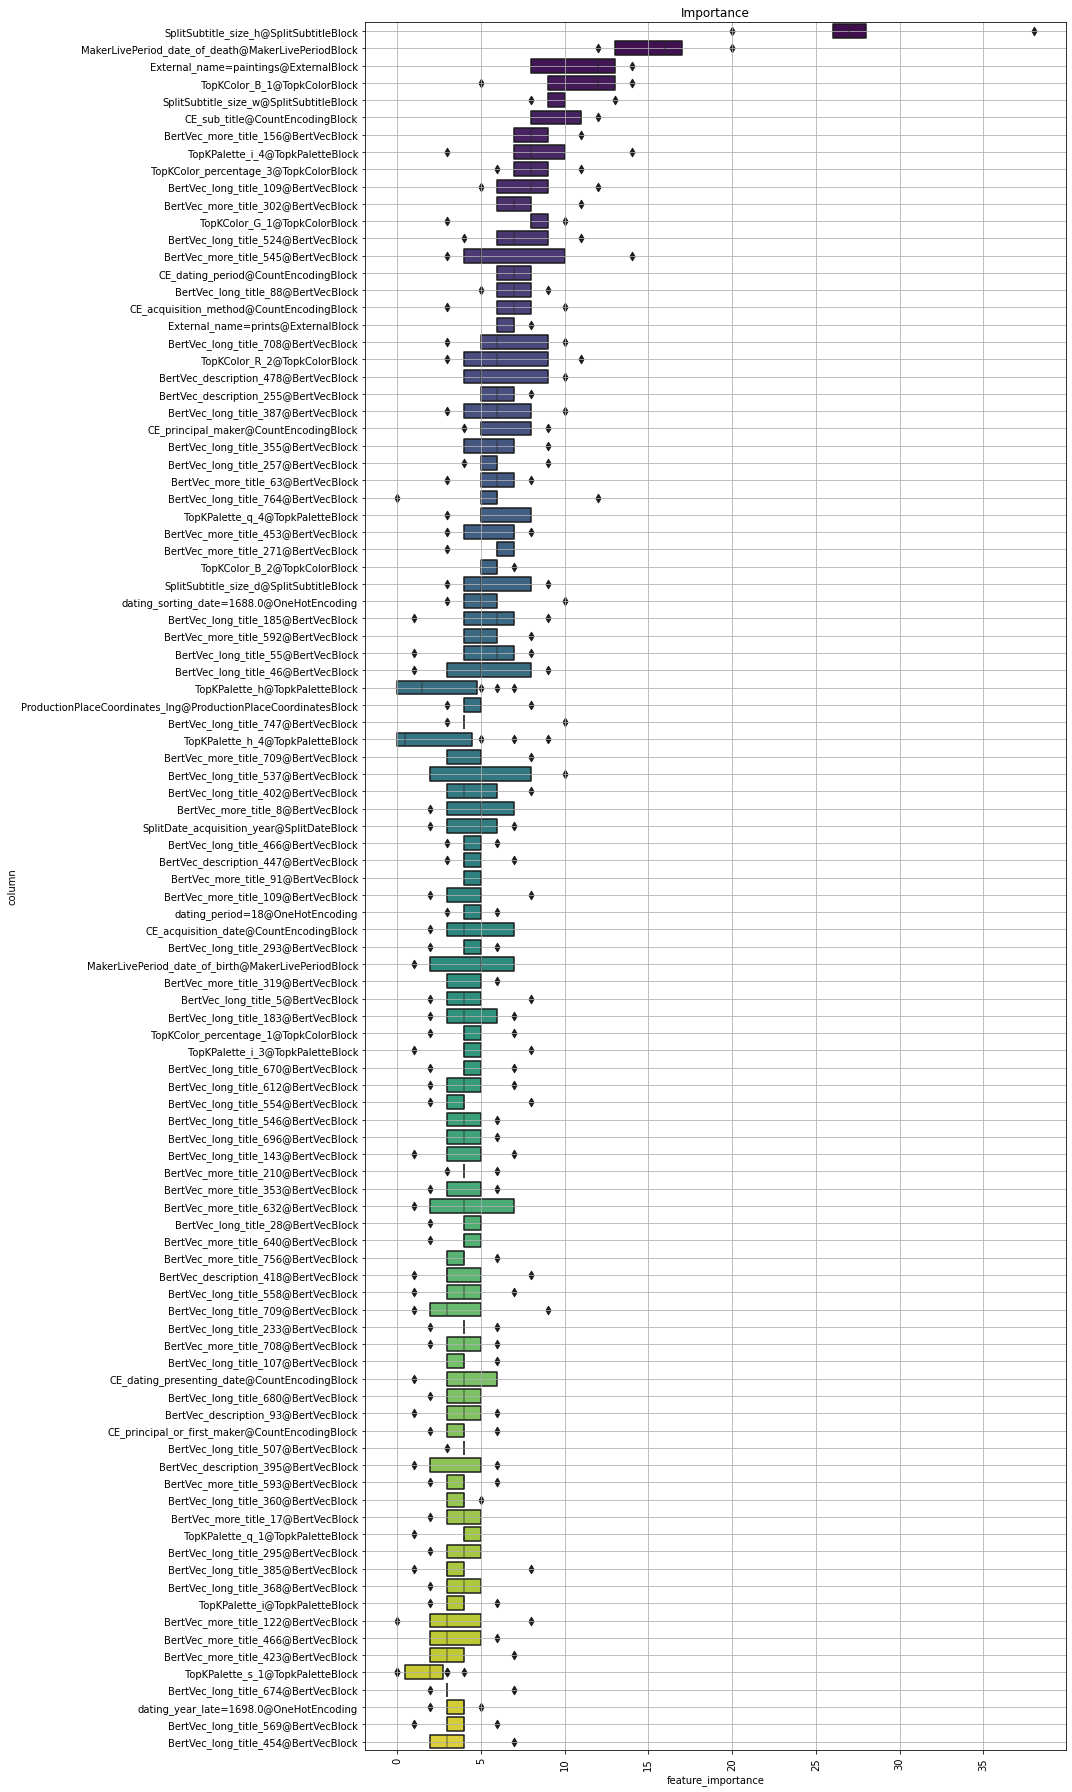

In [33]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:100]

    fig, ax = plt.subplots(figsize=(15, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    return fig, ax

fig, ax = visualize_importance(models, X_train)

## 推論

In [30]:
def revert_to_real(y_log):
    _pred = np.expm1(y_log)
    _pred = np.where(_pred < 0, 0, _pred)
    return _pred

pred = np.array([model.predict(X_test.values) for model in models])
pred = np.mean(pred, axis=0)
pred = revert_to_real(pred)
sub_df = pd.DataFrame({ 'likes': pred })
sub_df.to_csv(os.path.join(OUTPUT_DIR, 'baseline2(optuna)_submission.csv'), index=False)

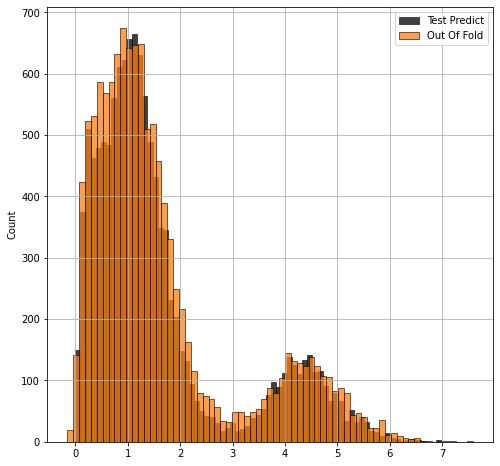

In [31]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(np.log1p(pred), label='Test Predict', ax=ax, color='black')
sns.histplot(oof, label='Out Of Fold', ax=ax, color='C1')
ax.legend()
ax.grid()

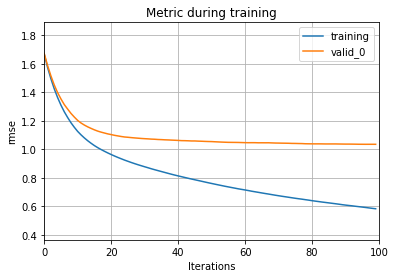

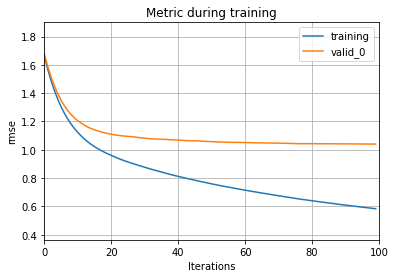

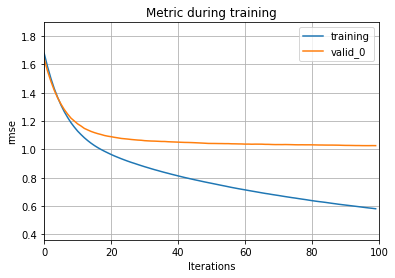

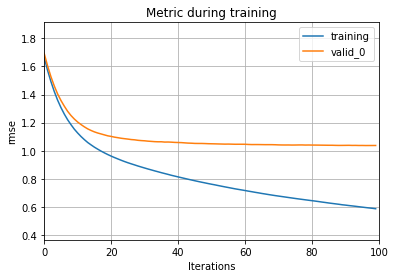

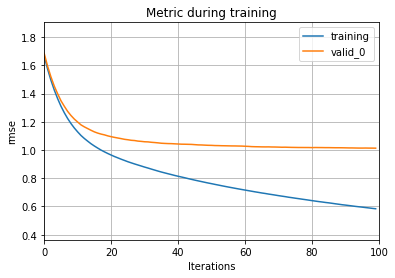

In [32]:
for model in models:
    lgbm.plot_metric(model)